# Introduction

In this tutorial, we will explain the basics of using Data Detective to perform a Data Investigation. In this tutorial, we will go through the steps of setting up and running a basic Data Detective Investigation, including: 
1. Configuring a dataset that works with Data Detective. 
2. Setting up a schema that defines the Data Detective investigation. 
3. Executing a data detective investigation. 
4. Summarizing results using the built-in Rank Aggregator


We will also include supplemental tutorials for some of Data Detective's more advanced features, including: 
- Extending the Data Detective investigation with custom validations
- Extending the transform library to map custom datatypes to supported datatypes


Let's get started!


In [1]:
import time
import torchvision.transforms as transforms

from typing import Dict

from src.actions.action import RemoveTopKAnomalousSamplesAction
from src.aggregation.rankings import ResultAggregator, RankingAggregationMethod, ScoreAggregationMethod
from src.data_detective_engine import DataDetectiveEngine
from src.datasets.tutorial_dataset import TutorialDataset
from src.datasets.data_detective_dataset import dd_random_split

%pdb

/Users/mcconnl3/Code/data-detective-load-test/dd_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/mcconnl3/Code/data-detective-load-test/dd_env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Automatic pdb calling has been turned ON


# Dataset Construction

## Requirements for a Dataset

For a dataset to work within the Data Detective framework, it needs to satisfy the following requirements: 

1. It must override the `__getitem__` method that returns a dictionary mapping from each data column key to the data value. 
2. It must contain a `datatypes` method that returns a dictionary mapping from each data column key to the column's datatype. 

Let's examine what this looks like in practice.


## Dataset Implementation

In this tutorial, we will create a heterogeneous dataset that consists of the following items: 

- MNIST images
- MNIST labels
- 10-dimensional normal distribution (μ=0, σ=1)

The full dataset can be found under src/datasets/tutorial_dataset.


In [2]:
dataset = TutorialDataset(
    root='./data/MNIST',
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor() 
    ])
)

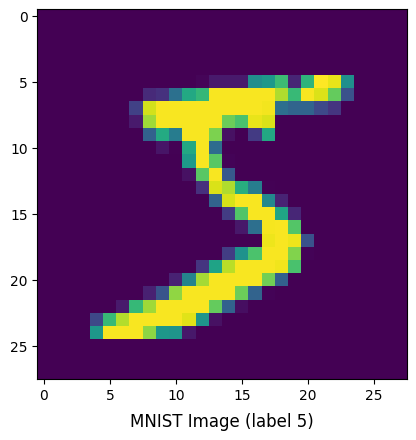

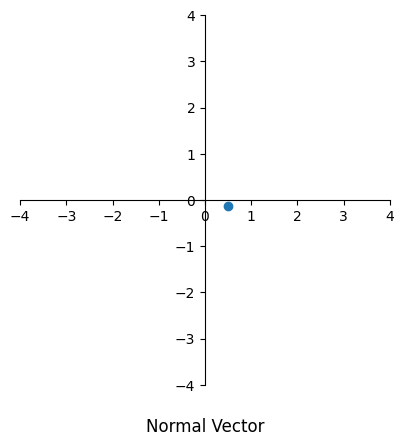

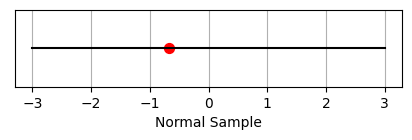

In [3]:
dataset.show_datapoint(0)

In [4]:
dataset[0]["normal_vector_2"]

-0.6751782749743815

# Setting up the Data Object

The *data object* is a dictionary that consists of the preprocessed dataset and (optionally) its splits. In order to make use of split validation techniques such as distribution shift between splits, the data splits must be included. 

There are 3 basic categories of split objects that can be included in the data object:
1. **The Entire Set**. This set consists of the entire dataset being analyzed. This is held under the key `entire_set`.
2. **Unordered Split Sets**. These are splits that are order-invariant for the purposes of analysis. For example, when doing covariate analysis between splits, the order and names of the dataset does not need to be specified to compare all datasets to all other datasets. They are defined as a nested dictionary under the key `split_group_set` under the key `split_group_set`; see the example below for more details. 
3. **Ordered Splits**. These are splits that are order-dependent for the purposes of analysis. For example, when doing OOD detection, it is important to define a source dataset for training the OOD model and the target split for evaluation. 
   - Source/training splits are labeled as the `everything_but_inference_set`
   - Target/inference splits are labeled as the `inference_set`

The example below should clarify these distinctions.

In [5]:
inference_size: int = 20
everything_but_inference_size: int = dataset.__len__() - inference_size
inference_dataset, everything_but_inference_dataset = dd_random_split(dataset, [inference_size, dataset.__len__() - inference_size])
    
train_size: int = int(0.6 * len(everything_but_inference_dataset))
val_size: int = int(0.2 * len(everything_but_inference_dataset))
test_size: int = len(everything_but_inference_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = dd_random_split(everything_but_inference_dataset, [train_size, val_size, test_size])

data_object = {
    "entire_set": dataset,
    "everything_but_inference_set": everything_but_inference_dataset,
    "inference_set": inference_dataset,
    "train/val/test": {
        "training_set": train_dataset,
        "validation_set": val_dataset,
        "test_set": test_dataset,
    },
}

print(f"size of inference_dataset: {inference_dataset.__len__()}")
print(f"size of everything_but_inference_dataset: {everything_but_inference_dataset.__len__()}")
print(f"size of train_dataset: {train_dataset.__len__()}")
print(f"size of entire dataset: {dataset.__len__()}")
print(f"size of val_dataset: {val_dataset.__len__()}")
print(f"size of test_dataset: {test_dataset.__len__()}")

size of inference_dataset: 20
size of everything_but_inference_dataset: 980
size of train_dataset: 588
size of entire dataset: 1000
size of val_dataset: 196
size of test_dataset: 196


# Setting up a Validation Schema

## Specifying Validators and Options

The validation schema contains information about the types of checks that will be executed by the Data Detective Engine and the transforms that Data Detective will use. Before discussing the validation schema, it is important to define two key modular components that make up Data Detective investigations. Data Detective's functionality can be divided into a modular, implementation-heavy component referred to as a *validator method* and an easily toggleable component referred to as a *validator*.

A *validator method* performs a specific type of test for a data issue on a specific data type. These validator methods primarily consist of the code needed to take a dataset and run an evaluation on it that produces either a positive or negative result or a score. Some examples of validator methods include:
- Mann-Whitney U-Test to examine distribution shift between train/test splits on tabular data
- Kernel Conditional Independence (KCI) test for validating causal assumptions on vectorvalued
data
- Isolation forest trained/evaluated on image histograms for identifying anomalies in imaging
data

*Validations* are toggleable, datatype-agnostic collections of validator methods that are serially applied to the dataset. Each validator targets a single problem that may arise in data, including: 
- Shift between different data splits
- Outlier and anomaly detection
- Violation of parametric assumptions on the data
- Violation of expected casual structures / conditional independences in the 

In the validation schema, users only specify the validators that they would like to use. This abstracts away details concerning what methods should be used for which columns and simplifies the process for searching for a particular flavor of issues to a few lines of code. Below is the validation schema that we will use for the tutorial. 

In [6]:
validation_schema : Dict = {
    "default_inclusion": False,
    "validators": {
        "unsupervised_anomaly_data_validator": {
            "validator_kwargs":{
                "should_return_model_instance": True
            }
        },
        # "unsupervised_multimodal_anomaly_data_validator": {},
        # "split_covariate_data_validator": {},
        # "ood_inference_data_validator": {}
    }
}

A few notes: 
- Each validator maps to an object that specifies additional options. For this tutorial, we will use the default settings, but these options include: 
  - special kwargs to include and pass to the validator methods
  - additional filtering regarding which columns the validator should be applied to
 
  
  
 

## Specifying Transforms

It may be the case that you are using a data modality that has little to no method infrastructure in Data Detective. The simplest way to make use of all of Data Detective's functionality is to use a transform that maps this data modality to a well-supported modality in Data Detective such as multidimensional data. In our example, we will be making use of a pretrained resnet50 backbone to map our MNIST images to 2048 dimensional vectors. This will allow us to make use of methods built for multidimensional data on our MNIST image representations.

In [7]:
transform_schema : Dict = {
    "transforms": {
        "IMAGE": [{
            "name": "resnet50",
            "in_place": "False",
            "options": {},
        }],
    }
}
     
full_validation_schema: Dict = {
    **validation_schema, 
    **transform_schema
}

# Running the Data Detective Engine

Now that the full validation schema and data object are prepared, we are ready to run the Data Detective Engine.

In [8]:
data_detective_engine = DataDetectiveEngine()

# 1 thread, --- 220.85648322105408 seconds ---
# multithreadinng (joblib), --- 149.11400604248047 seconds ---
# thread pools, --- 81.38025784492493 seconds ---
# data-level caching, clean cache, --- 75.22503590583801 seconds ---
# sample-level caching, clean cache--- 26.184876918792725 seconds ---
# data-level caching, dirty cache, --- 22.925609827041626 seconds ---
# sample-level caching, dirty cache, --- 19.73765206336975 seconds ---

start_time = time.time()
results = data_detective_engine.validate_from_schema(full_validation_schema, data_object, run_concurrently=True)
print("--- %s seconds ---" % (time.time() - start_time))

Cache loaded from data/tmp/cache.pkl
running validator class unsupervised_anomaly_data_validator...
process 47299 entered to handle validator method pca_anomaly_validator_method
process 47299:    running pca_anomaly_validator_method...
process 47299: preparing 1...
process 47299: preparing 2...
process 47299: preparing 3...
process 47299: column 1
process 47299, matrix_dict col normal_vector id before: 10844159168
process 47299, matrix_dict col normal_vector_2 id before: 4422734144
process 47299, matrix_dict col label id before: 4422734336
process 47299, matrix_dict col resnet50_backbone_mnist_image id before: 11371472000
process 47299, dataset id: 11372053888
process 47299, mnist id: 11371673824
process 47299: column 3
process 47299: column 4
process 47299: column 5
process 47299: column 5
process 47299: column 6
process 47299: column 5
process 47299: column 6
process 47299: column 5
process 47299: column 6
process 47299: column 5
process 47299: column 6
process 47299: column 7
normal

/Users/mcconnl3/Code/data-detective-load-test/dd_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


process 47300: finished
process 47301: validating...


/Users/mcconnl3/Code/data-detective-load-test/dd_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


process 47301: validating...


/Users/mcconnl3/Code/data-detective-load-test/dd_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


process 47301: validating...


/Users/mcconnl3/Code/data-detective-load-test/dd_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


process 47299: finished
process 47301: finished
[('unsupervised_anomaly_data_validator', 'pca_anomaly_validator_method', {'normal_vector_results': ({'0': 5.575476679289533, '1': 8.143321159867202, '2': 3.3687293266151372, '3': 10.049063411111124, '4': 2.982092597763974, '5': 3.019841772226372, '6': 8.703759520391646, '7': 5.71696209300151, '8': 3.249804863215176, '9': 5.931618178682497, '10': 9.29571913196387, '11': 6.705585129137155, '12': 2.859785630091237, '13': 3.60557235433904, '14': 2.8403671611647816, '15': 7.074534426430678, '16': 5.382947763294072, '17': 8.236494543020106, '18': 8.802194018992088, '19': 4.0245039243553675, '20': 6.43256402141267, '21': 3.705514592124327, '22': 5.156783147660333, '23': 4.079466924320521, '24': 8.41141623967766, '25': 5.143811303511161, '26': 2.829828585670248, '27': 8.19489728449477, '28': 2.977181449901086, '29': 5.881591363396517, '30': 2.925198964881643, '31': 5.433196103464332, '32': 8.243326671733609, '33': 4.763537951919178, '34': 5.59889

In [9]:
results

{'unsupervised_anomaly_data_validator': {'pca_anomaly_validator_method': {'normal_vector_results': ({'0': 5.575476679289533,
     '1': 8.143321159867202,
     '2': 3.3687293266151372,
     '3': 10.049063411111124,
     '4': 2.982092597763974,
     '5': 3.019841772226372,
     '6': 8.703759520391646,
     '7': 5.71696209300151,
     '8': 3.249804863215176,
     '9': 5.931618178682497,
     '10': 9.29571913196387,
     '11': 6.705585129137155,
     '12': 2.859785630091237,
     '13': 3.60557235433904,
     '14': 2.8403671611647816,
     '15': 7.074534426430678,
     '16': 5.382947763294072,
     '17': 8.236494543020106,
     '18': 8.802194018992088,
     '19': 4.0245039243553675,
     '20': 6.43256402141267,
     '21': 3.705514592124327,
     '22': 5.156783147660333,
     '23': 4.079466924320521,
     '24': 8.41141623967766,
     '25': 5.143811303511161,
     '26': 2.829828585670248,
     '27': 8.19489728449477,
     '28': 2.977181449901086,
     '29': 5.881591363396517,
     '30': 2.925

Great! Let's start to look at and analyze the results we've collected.

# Aggregating + Examining Results using the Built-In Result Aggregator

In [10]:
aggregator = ResultAggregator(results_object=results)
modal_rankings = aggregator.aggregate_results_modally("unsupervised_anomaly_data_validator", [RankingAggregationMethod.LOWEST_RANK, RankingAggregationMethod.HIGHEST_RANK, RankingAggregationMethod.ROUND_ROBIN], given_data_modality="resnet50_backbone_mnist_image")
total_rankings = aggregator.aggregate_results_multimodally("unsupervised_anomaly_data_validator", [RankingAggregationMethod.LOWEST_RANK, RankingAggregationMethod.HIGHEST_RANK, RankingAggregationMethod.ROUND_ROBIN, ScoreAggregationMethod.NORMALIZED_AVERAGE])
# rankings = total_rankings
rankings = modal_rankings

rankings

,resnet50_backbone_mnist_image_results_pca_anomaly_validator_method_rank,resnet50_backbone_mnist_image_results_iforest_anomaly_validator_method_rank,resnet50_backbone_mnist_image_results_cblof_anomaly_validator_method_rank,lowest_rank_agg_rank,highest_rank_agg_rank,round_robin_agg_rank,resnet50_backbone_mnist_image_results_pca_anomaly_validator_method_score,resnet50_backbone_mnist_image_results_iforest_anomaly_validator_method_score,resnet50_backbone_mnist_image_results_cblof_anomaly_validator_method_score
0,403,609,536,502,487,475,5.372308e+16,-0.045866,2.976066
1,67,88,81,48,106,103,6.665755e+16,0.002478,3.422877
10,2,9,1,3,1,2,9.429200e+16,0.038894,4.224386
100,743,951,763,896,834,826,4.848048e+16,-0.067387,2.769745
101,156,136,246,178,203,204,6.171000e+16,-0.006406,3.206527
...,...,...,...,...,...,...,...,...,...
995,737,762,607,663,707,695,4.860908e+16,-0.054946,2.921999
996,897,798,922,858,893,900,4.652665e+16,-0.056752,2.545427
997,329,162,285,252,232,240,5.536775e+16,-0.010208,3.175973
998,241,83,312,235,128,123,5.842981e+16,0.002795,3.157900


# Taking Action: Fixing our Dataset with Built-in Actions

In [11]:
action = RemoveTopKAnomalousSamplesAction()
new_data_object = action.get_new_data_object(
    data_object,
    rankings, 
    "round_robin_agg_rank"
)

10 samples removed and 10 datapoints removed.
removed samples {'435', '523', '400', '399', '10', '88', '778', '229', '984', '781'}


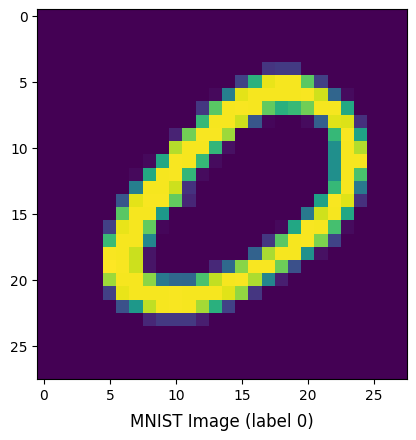

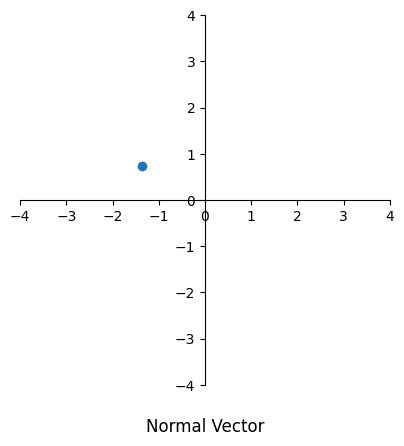

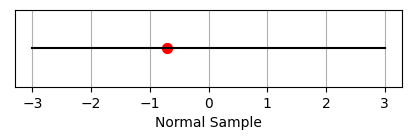

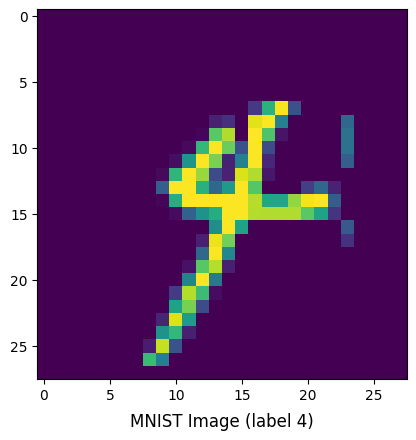

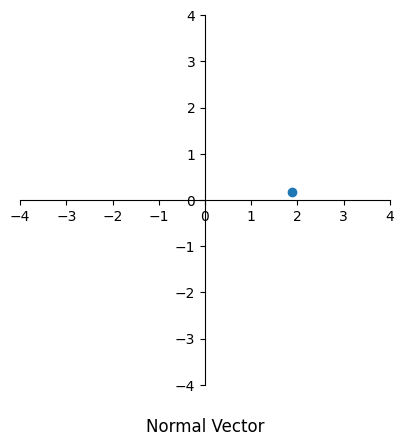

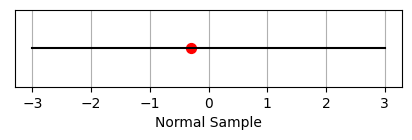

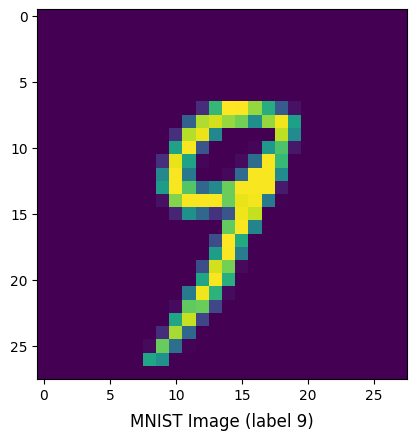

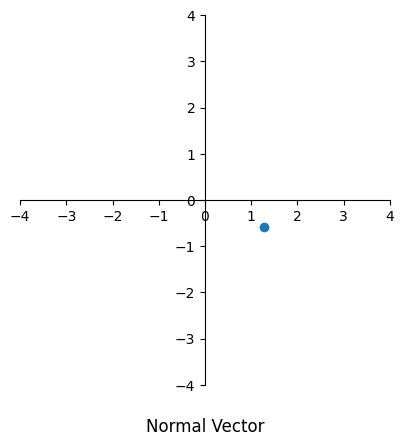

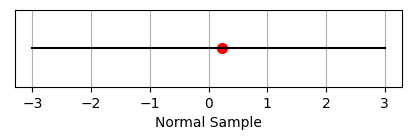

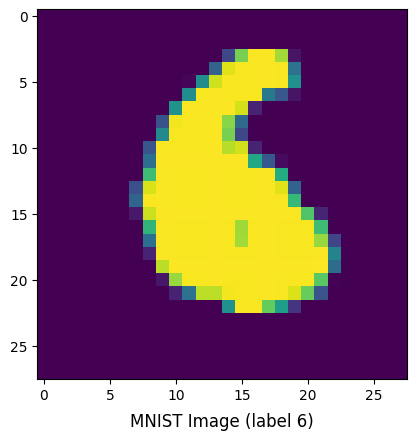

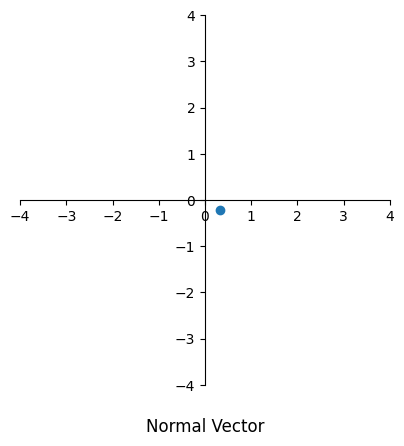

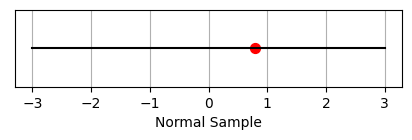

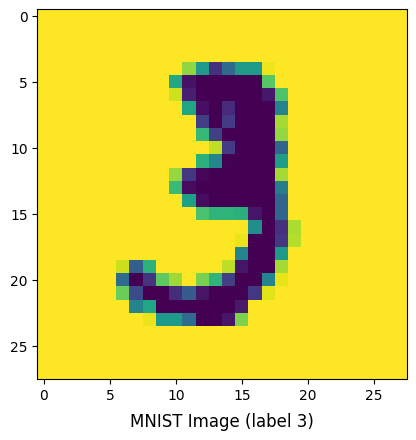

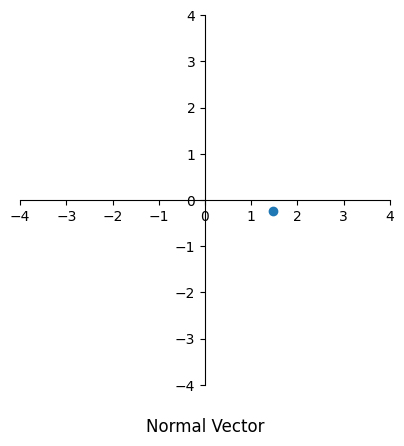

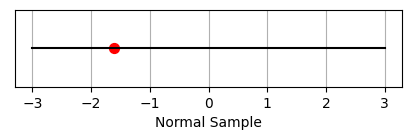

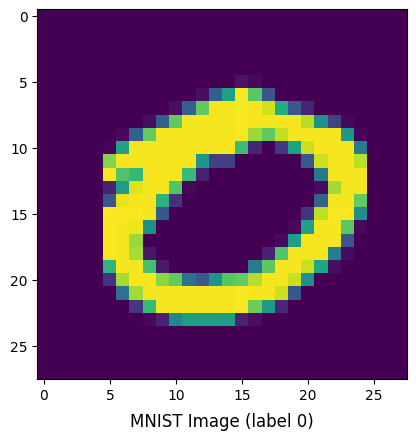

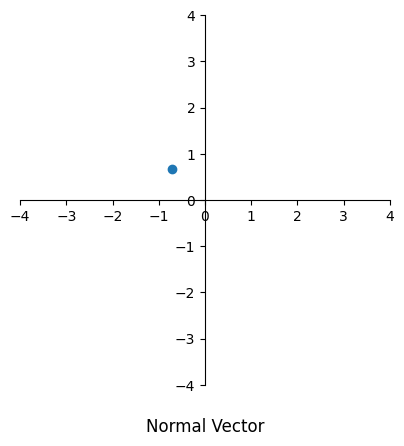

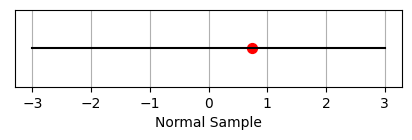

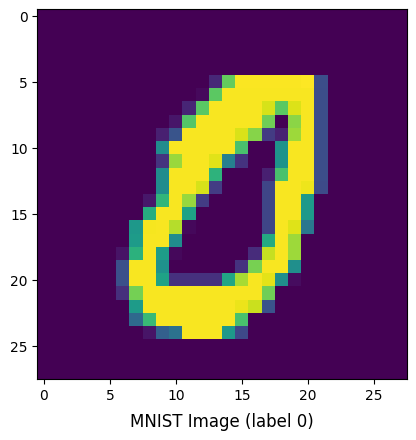

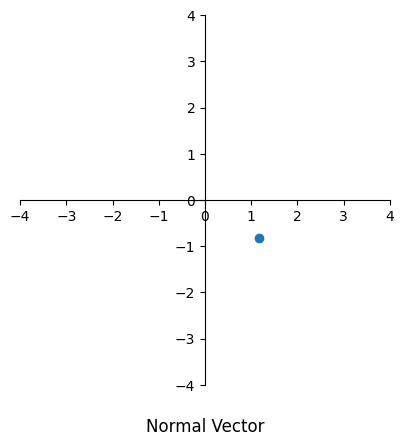

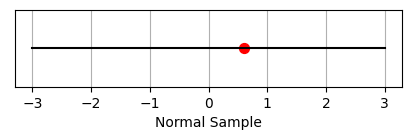

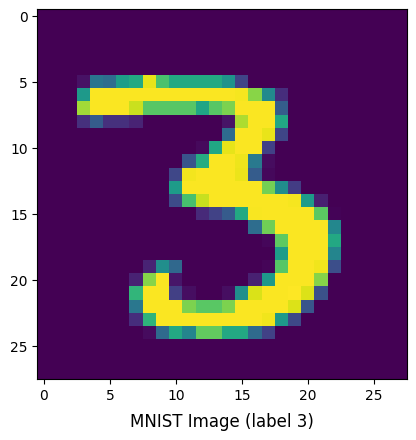

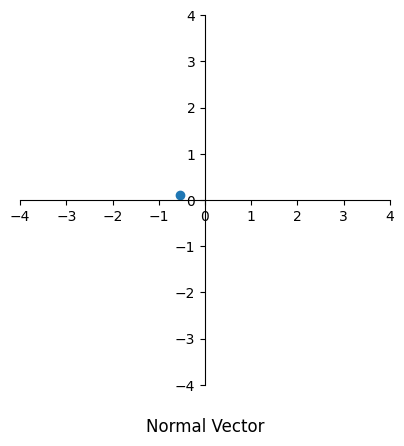

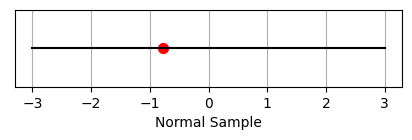

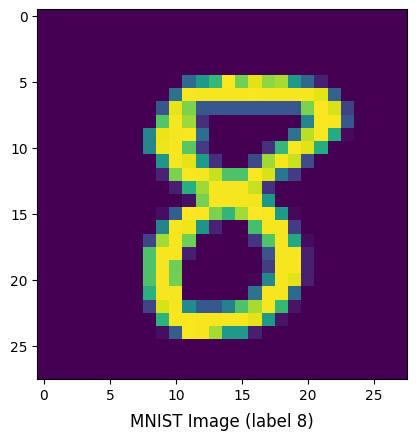

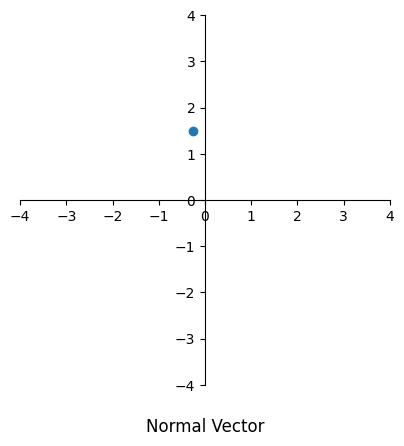

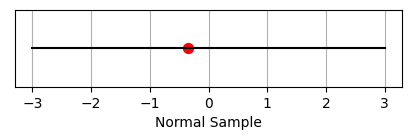

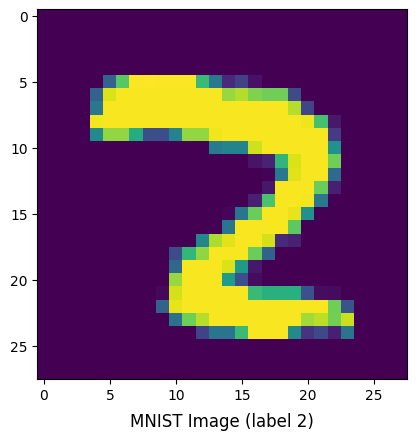

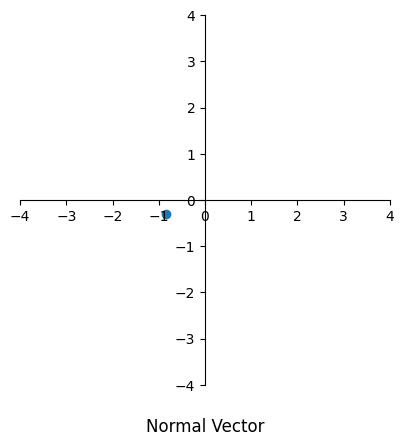

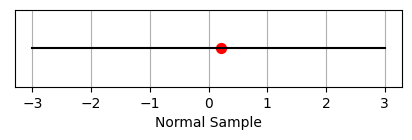

In [12]:
for val in {'114', '286', '28', '81', '153', '333', '53', '453', '12', '10'}:
    dataset.show_datapoint(int(val))

# Wait, but Why: Occlusion-Oriented Interpretability

Lets look at a couple examples.

Resnet50Transform(
  (backbone): Sequential(
    (0): Upsample(size=(224, 224), mode=nearest)
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (5): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)


 12%|█▏        | 93/784 [00:00<00:00, 900.22it/s]

in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform


 23%|██▎       | 184/784 [00:02<00:08, 74.62it/s]

in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform


 29%|██▊       | 224/784 [00:02<00:08, 66.82it/s]

in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform


 32%|███▏      | 248/784 [00:03<00:08, 62.92it/s]

in transform
in transform
in transform
in transform
in transform


 34%|███▍      | 265/784 [00:03<00:08, 63.09it/s]

in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform


 37%|███▋      | 289/784 [00:04<00:08, 61.69it/s]

in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform


 38%|███▊      | 299/784 [00:04<00:10, 46.90it/s]

in transform
in transform
in transform
in transform
in transform


 40%|████      | 316/784 [00:04<00:08, 57.11it/s]

in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform


 41%|████▏     | 325/784 [00:05<00:10, 44.21it/s]

in transform
in transform
in transform
in transform
in transform


 44%|████▍     | 347/784 [00:05<00:08, 54.11it/s]

in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform


 48%|████▊     | 377/784 [00:05<00:06, 62.32it/s]

in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform


 49%|████▉     | 387/784 [00:06<00:08, 46.57it/s]

in transform
in transform
in transform
in transform
in transform


 52%|█████▏    | 405/784 [00:06<00:06, 60.53it/s]

in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform


 55%|█████▍    | 431/784 [00:06<00:06, 58.08it/s]

in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform


 56%|█████▌    | 440/784 [00:07<00:07, 44.09it/s]

in transform
in transform
in transform
in transform
in transform


 58%|█████▊    | 457/784 [00:07<00:05, 58.37it/s]

in transform
in transform
in transform
in transform
in transform


 59%|█████▉    | 466/784 [00:07<00:07, 42.43it/s]

in transform
in transform
in transform
in transform
in transform


 60%|██████    | 473/784 [00:08<00:07, 42.13it/s]

in transform
in transform
in transform
in transform
in transform


 63%|██████▎   | 493/784 [00:08<00:04, 62.15it/s]

in transform
in transform
in transform
in transform
in transform


 66%|██████▋   | 520/784 [00:08<00:03, 75.02it/s]

in transform
in transform
in transform
in transform
in transform


 68%|██████▊   | 530/784 [00:08<00:04, 61.24it/s]

in transform
in transform
in transform
in transform
in transform


 69%|██████▉   | 542/784 [00:08<00:03, 68.20it/s]

in transform
in transform
in transform
in transform
in transform


 70%|███████   | 551/784 [00:09<00:04, 52.97it/s]

in transform
in transform
in transform
in transform
in transform


 71%|███████   | 558/784 [00:09<00:04, 53.43it/s]

in transform
in transform
in transform
in transform
in transform


 73%|███████▎  | 570/784 [00:09<00:03, 62.27it/s]

in transform
in transform
in transform
in transform
in transform


 74%|███████▎  | 578/784 [00:09<00:04, 43.54it/s]

in transform
in transform
in transform
in transform
in transform


 74%|███████▍  | 584/784 [00:10<00:04, 41.54it/s]

in transform
in transform
in transform
in transform
in transform


 76%|███████▋  | 598/784 [00:10<00:03, 55.42it/s]

in transform
in transform
in transform
in transform
in transform


 77%|███████▋  | 605/784 [00:10<00:04, 41.17it/s]

in transform
in transform
in transform
in transform
in transform


 78%|███████▊  | 611/784 [00:10<00:04, 37.63it/s]

in transform
in transform
in transform
in transform
in transform


 80%|███████▉  | 626/784 [00:10<00:02, 53.30it/s]

in transform
in transform
in transform
in transform
in transform


 81%|████████  | 633/784 [00:11<00:03, 41.39it/s]

in transform
in transform
in transform
in transform
in transform


 82%|████████▏ | 639/784 [00:11<00:03, 37.40it/s]

in transform
in transform
in transform
in transform
in transform


 84%|████████▍ | 660/784 [00:11<00:01, 62.01it/s]

in transform
in transform
in transform
in transform
in transform


 87%|████████▋ | 682/784 [00:11<00:01, 65.65it/s]

in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform


 89%|████████▉ | 697/784 [00:12<00:01, 47.24it/s]

in transform
in transform
in transform
in transform
in transform


 91%|█████████ | 710/784 [00:12<00:01, 57.86it/s]

in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform


 94%|█████████▍| 736/784 [00:12<00:00, 60.23it/s]

in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform


100%|██████████| 784/784 [00:13<00:00, 58.74it/s]

in transform
in transform
in transform


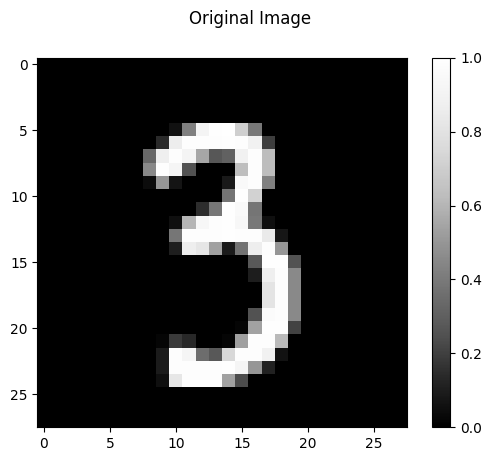

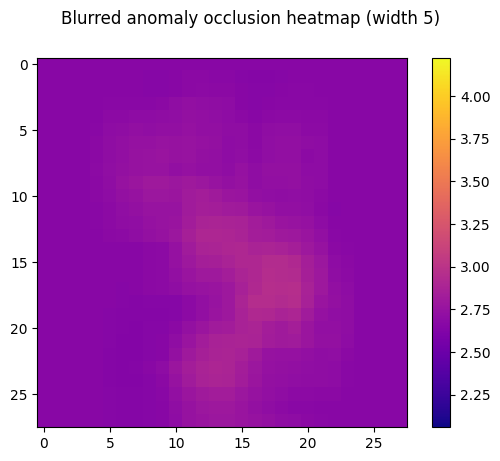

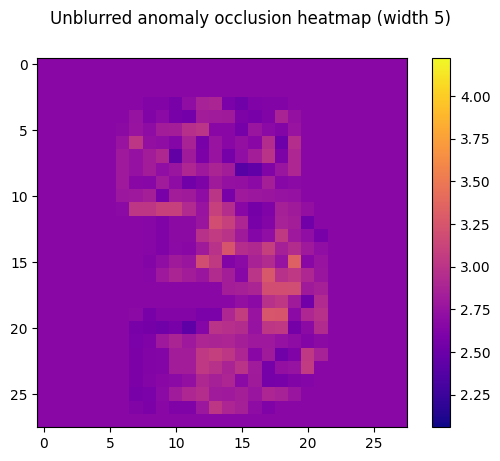

  0%|          | 3/784 [00:00<00:34, 22.59it/s]

in transform
in transform
in transform
in transform
in transform


  1%|          | 9/784 [00:00<00:34, 22.67it/s]

in transform
in transform
in transform
in transform
in transform


  2%|▏         | 12/784 [00:00<00:34, 22.14it/s]

in transform
in transform
in transform
in transform
in transform


  2%|▏         | 18/784 [00:00<00:33, 22.62it/s]

in transform
in transform
in transform
in transform
in transform


  3%|▎         | 24/784 [00:01<00:33, 22.66it/s]

in transform
in transform
in transform
in transform
in transform


  3%|▎         | 27/784 [00:01<00:33, 22.52it/s]

in transform
in transform
in transform
in transform
in transform


  4%|▍         | 33/784 [00:01<00:33, 22.27it/s]

in transform
in transform
in transform
in transform
in transform


  5%|▍         | 39/784 [00:01<00:33, 22.38it/s]

in transform
in transform
in transform
in transform
in transform


  5%|▌         | 42/784 [00:01<00:33, 21.84it/s]

in transform
in transform
in transform
in transform
in transform


  6%|▌         | 48/784 [00:02<00:33, 22.16it/s]

in transform
in transform
in transform
in transform
in transform


  7%|▋         | 54/784 [00:02<00:33, 21.47it/s]

in transform
in transform
in transform
in transform
in transform


  7%|▋         | 57/784 [00:02<00:33, 21.88it/s]

in transform
in transform
in transform
in transform
in transform


  8%|▊         | 63/784 [00:02<00:34, 21.18it/s]

in transform
in transform
in transform
in transform


  8%|▊         | 66/784 [00:02<00:33, 21.27it/s]

in transform
in transform
in transform
in transform
in transform


  9%|▉         | 72/784 [00:03<00:32, 22.21it/s]

in transform
in transform
in transform
in transform
in transform


 10%|▉         | 78/784 [00:03<00:32, 21.67it/s]

in transform
in transform
in transform
in transform
in transform


 10%|█         | 81/784 [00:03<00:32, 21.80it/s]

in transform
in transform
in transform
in transform
in transform


 11%|█         | 87/784 [00:03<00:30, 22.58it/s]

in transform
in transform
in transform
in transform
in transform


 12%|█▏        | 93/784 [00:04<00:30, 22.79it/s]

in transform
in transform
in transform
in transform
in transform


 12%|█▏        | 96/784 [00:04<00:30, 22.92it/s]

in transform
in transform
in transform
in transform
in transform


 13%|█▎        | 102/784 [00:04<00:29, 23.19it/s]

in transform
in transform
in transform
in transform
in transform


 14%|█▍        | 108/784 [00:04<00:29, 23.23it/s]

in transform
in transform
in transform
in transform
in transform


 14%|█▍        | 111/784 [00:04<00:28, 23.24it/s]

in transform
in transform
in transform
in transform
in transform


 15%|█▍        | 117/784 [00:05<00:28, 23.25it/s]

in transform
in transform
in transform
in transform
in transform


 16%|█▌        | 123/784 [00:05<00:28, 22.93it/s]

in transform
in transform
in transform
in transform
in transform


 16%|█▌        | 126/784 [00:05<00:28, 22.85it/s]

in transform
in transform
in transform
in transform
in transform


 17%|█▋        | 132/784 [00:05<00:28, 23.08it/s]

in transform
in transform
in transform
in transform
in transform


 18%|█▊        | 138/784 [00:06<00:28, 22.92it/s]

in transform
in transform
in transform
in transform
in transform


 18%|█▊        | 141/784 [00:06<00:28, 22.91it/s]

in transform
in transform
in transform
in transform
in transform


 19%|█▉        | 147/784 [00:06<00:28, 22.59it/s]

in transform
in transform
in transform
in transform
in transform


 20%|█▉        | 153/784 [00:06<00:27, 22.77it/s]

in transform
in transform
in transform
in transform
in transform


 20%|█▉        | 156/784 [00:06<00:27, 22.84it/s]

in transform
in transform
in transform
in transform
in transform


 21%|██        | 162/784 [00:07<00:27, 22.50it/s]

in transform
in transform
in transform
in transform
in transform


 21%|██▏       | 168/784 [00:07<00:27, 22.22it/s]

in transform
in transform
in transform
in transform
in transform


 22%|██▏       | 171/784 [00:07<00:27, 22.42it/s]

in transform
in transform
in transform
in transform
in transform


 23%|██▎       | 177/784 [00:07<00:27, 22.31it/s]

in transform
in transform
in transform
in transform
in transform


 23%|██▎       | 183/784 [00:08<00:26, 22.72it/s]

in transform
in transform
in transform
in transform
in transform


 24%|██▎       | 186/784 [00:08<00:26, 22.83it/s]

in transform
in transform
in transform
in transform
in transform


 24%|██▍       | 192/784 [00:08<00:25, 23.12it/s]

in transform
in transform
in transform
in transform
in transform


 25%|██▌       | 198/784 [00:08<00:25, 23.20it/s]

in transform
in transform
in transform
in transform
in transform


 26%|██▌       | 201/784 [00:08<00:25, 23.26it/s]

in transform
in transform
in transform
in transform
in transform


 26%|██▋       | 207/784 [00:09<00:24, 23.23it/s]

in transform
in transform
in transform
in transform
in transform


 27%|██▋       | 213/784 [00:09<00:24, 22.99it/s]

in transform
in transform
in transform
in transform
in transform


 28%|██▊       | 216/784 [00:09<00:24, 23.09it/s]

in transform
in transform
in transform
in transform
in transform


 28%|██▊       | 222/784 [00:09<00:25, 22.32it/s]

in transform
in transform
in transform
in transform
in transform


 29%|██▉       | 228/784 [00:10<00:24, 22.60it/s]

in transform
in transform
in transform
in transform
in transform


 29%|██▉       | 231/784 [00:10<00:24, 22.42it/s]

in transform
in transform
in transform
in transform
in transform


 30%|███       | 237/784 [00:10<00:25, 21.63it/s]

in transform
in transform
in transform
in transform
in transform


 31%|███       | 243/784 [00:10<00:24, 21.70it/s]

in transform
in transform
in transform
in transform
in transform


 31%|███▏      | 246/784 [00:10<00:24, 21.82it/s]

in transform
in transform
in transform
in transform
in transform


 32%|███▏      | 252/784 [00:11<00:24, 21.64it/s]

in transform
in transform
in transform
in transform
in transform


 33%|███▎      | 258/784 [00:11<00:24, 21.74it/s]

in transform
in transform
in transform
in transform
in transform


 33%|███▎      | 261/784 [00:11<00:23, 22.10it/s]

in transform
in transform
in transform
in transform
in transform


 34%|███▍      | 267/784 [00:11<00:23, 22.41it/s]

in transform
in transform
in transform
in transform
in transform


 35%|███▍      | 273/784 [00:12<00:23, 21.38it/s]

in transform
in transform
in transform
in transform
in transform


 35%|███▌      | 276/784 [00:12<00:23, 21.76it/s]

in transform
in transform
in transform
in transform
in transform


 36%|███▌      | 282/784 [00:12<00:22, 22.42it/s]

in transform
in transform
in transform
in transform
in transform


 37%|███▋      | 288/784 [00:12<00:21, 22.84it/s]

in transform
in transform
in transform
in transform
in transform


 37%|███▋      | 291/784 [00:12<00:21, 22.85it/s]

in transform
in transform
in transform
in transform
in transform


 38%|███▊      | 297/784 [00:13<00:21, 22.98it/s]

in transform
in transform
in transform
in transform
in transform


 39%|███▊      | 303/784 [00:13<00:20, 22.99it/s]

in transform
in transform
in transform
in transform
in transform


 39%|███▉      | 306/784 [00:13<00:20, 23.05it/s]

in transform
in transform
in transform
in transform
in transform


 40%|███▉      | 312/784 [00:13<00:20, 23.21it/s]

in transform
in transform
in transform
in transform
in transform


 41%|████      | 318/784 [00:14<00:20, 23.25it/s]

in transform
in transform
in transform
in transform
in transform


 41%|████      | 321/784 [00:14<00:20, 22.62it/s]

in transform
in transform
in transform
in transform
in transform


 42%|████▏     | 327/784 [00:14<00:21, 21.61it/s]

in transform
in transform
in transform
in transform
in transform


 42%|████▏     | 333/784 [00:14<00:20, 21.89it/s]

in transform
in transform
in transform
in transform
in transform


 43%|████▎     | 336/784 [00:14<00:20, 22.22it/s]

in transform
in transform
in transform
in transform
in transform


 44%|████▎     | 342/784 [00:15<00:19, 22.78it/s]

in transform
in transform
in transform
in transform
in transform


 44%|████▍     | 348/784 [00:15<00:19, 22.44it/s]

in transform
in transform
in transform
in transform
in transform


 45%|████▍     | 351/784 [00:15<00:19, 22.67it/s]

in transform
in transform
in transform
in transform
in transform


 46%|████▌     | 357/784 [00:15<00:18, 23.17it/s]

in transform
in transform
in transform
in transform
in transform


 46%|████▋     | 363/784 [00:16<00:18, 23.17it/s]

in transform
in transform
in transform
in transform
in transform


 47%|████▋     | 366/784 [00:16<00:18, 23.07it/s]

in transform
in transform
in transform
in transform
in transform


 47%|████▋     | 372/784 [00:16<00:17, 23.15it/s]

in transform
in transform
in transform
in transform
in transform


 48%|████▊     | 378/784 [00:16<00:17, 23.17it/s]

in transform
in transform
in transform
in transform
in transform


 49%|████▊     | 381/784 [00:16<00:17, 23.25it/s]

in transform
in transform
in transform
in transform
in transform


 49%|████▉     | 387/784 [00:17<00:17, 23.18it/s]

in transform
in transform
in transform
in transform
in transform


 50%|█████     | 393/784 [00:17<00:16, 23.28it/s]

in transform
in transform
in transform
in transform
in transform


 51%|█████     | 396/784 [00:17<00:16, 23.15it/s]

in transform
in transform
in transform
in transform
in transform


 51%|█████▏    | 402/784 [00:17<00:16, 23.20it/s]

in transform
in transform
in transform
in transform
in transform


 52%|█████▏    | 408/784 [00:18<00:16, 23.24it/s]

in transform
in transform
in transform
in transform
in transform


 52%|█████▏    | 411/784 [00:18<00:16, 23.12it/s]

in transform
in transform
in transform
in transform
in transform


 53%|█████▎    | 417/784 [00:18<00:15, 23.11it/s]

in transform
in transform
in transform
in transform
in transform


 54%|█████▍    | 423/784 [00:18<00:15, 23.03it/s]

in transform
in transform
in transform
in transform
in transform


 54%|█████▍    | 426/784 [00:18<00:15, 23.05it/s]

in transform
in transform
in transform
in transform
in transform


 55%|█████▌    | 432/784 [00:19<00:15, 23.08it/s]

in transform
in transform
in transform
in transform
in transform


 56%|█████▌    | 438/784 [00:19<00:14, 23.08it/s]

in transform
in transform
in transform
in transform
in transform


 56%|█████▋    | 441/784 [00:19<00:14, 23.05it/s]

in transform
in transform
in transform
in transform
in transform


 57%|█████▋    | 447/784 [00:19<00:14, 22.94it/s]

in transform
in transform
in transform
in transform
in transform


 58%|█████▊    | 453/784 [00:20<00:14, 22.32it/s]

in transform
in transform
in transform
in transform
in transform


 58%|█████▊    | 456/784 [00:20<00:14, 22.59it/s]

in transform
in transform
in transform
in transform
in transform


 59%|█████▉    | 462/784 [00:20<00:14, 22.87it/s]

in transform
in transform
in transform
in transform
in transform


 60%|█████▉    | 468/784 [00:20<00:13, 23.04it/s]

in transform
in transform
in transform
in transform
in transform


 60%|██████    | 471/784 [00:20<00:13, 23.03it/s]

in transform
in transform
in transform
in transform
in transform


 61%|██████    | 477/784 [00:21<00:13, 22.65it/s]

in transform
in transform
in transform
in transform
in transform


 62%|██████▏   | 483/784 [00:21<00:13, 22.90it/s]

in transform
in transform
in transform
in transform
in transform


 62%|██████▏   | 486/784 [00:21<00:13, 22.92it/s]

in transform
in transform
in transform
in transform
in transform


 63%|██████▎   | 492/784 [00:21<00:12, 23.13it/s]

in transform
in transform
in transform
in transform
in transform


 64%|██████▎   | 498/784 [00:22<00:12, 23.05it/s]

in transform
in transform
in transform
in transform
in transform


 64%|██████▍   | 501/784 [00:22<00:12, 22.92it/s]

in transform
in transform
in transform
in transform
in transform


 65%|██████▍   | 507/784 [00:22<00:12, 22.57it/s]

in transform
in transform
in transform
in transform
in transform


 65%|██████▌   | 513/784 [00:22<00:12, 22.01it/s]

in transform
in transform
in transform
in transform
in transform


 66%|██████▌   | 516/784 [00:22<00:12, 21.30it/s]

in transform
in transform
in transform
in transform
in transform


 67%|██████▋   | 522/784 [00:23<00:13, 20.13it/s]

in transform
in transform
in transform
in transform


 67%|██████▋   | 525/784 [00:23<00:12, 20.04it/s]

in transform
in transform
in transform
in transform
in transform


 68%|██████▊   | 531/784 [00:23<00:12, 20.04it/s]

in transform
in transform
in transform
in transform
in transform


 68%|██████▊   | 537/784 [00:23<00:11, 20.94it/s]

in transform
in transform
in transform
in transform
in transform


 69%|██████▉   | 540/784 [00:23<00:11, 21.39it/s]

in transform
in transform
in transform
in transform
in transform


 70%|██████▉   | 546/784 [00:24<00:10, 22.13it/s]

in transform
in transform
in transform
in transform
in transform


 70%|███████   | 552/784 [00:24<00:10, 22.17it/s]

in transform
in transform
in transform
in transform
in transform


 71%|███████   | 555/784 [00:24<00:10, 22.27it/s]

in transform
in transform
in transform
in transform
in transform


 72%|███████▏  | 561/784 [00:24<00:09, 22.76it/s]

in transform
in transform
in transform
in transform
in transform


 72%|███████▏  | 567/784 [00:25<00:09, 22.15it/s]

in transform
in transform
in transform
in transform
in transform


 73%|███████▎  | 570/784 [00:25<00:09, 21.84it/s]

in transform
in transform
in transform
in transform
in transform


 73%|███████▎  | 576/784 [00:25<00:09, 22.50it/s]

in transform
in transform
in transform
in transform
in transform


 74%|███████▍  | 579/784 [00:25<00:09, 20.82it/s]

in transform
in transform
in transform
in transform


 75%|███████▍  | 585/784 [00:26<00:09, 21.00it/s]

in transform
in transform
in transform
in transform
in transform


 75%|███████▌  | 591/784 [00:26<00:08, 21.63it/s]

in transform
in transform
in transform
in transform
in transform


 76%|███████▌  | 594/784 [00:26<00:08, 21.21it/s]

in transform
in transform
in transform
in transform
in transform


 77%|███████▋  | 600/784 [00:26<00:08, 21.89it/s]

in transform
in transform
in transform
in transform
in transform


 77%|███████▋  | 606/784 [00:27<00:08, 21.46it/s]

in transform
in transform
in transform
in transform
in transform


 78%|███████▊  | 609/784 [00:27<00:08, 21.73it/s]

in transform
in transform
in transform
in transform
in transform


 78%|███████▊  | 615/784 [00:27<00:07, 22.56it/s]

in transform
in transform
in transform
in transform
in transform


 79%|███████▉  | 621/784 [00:27<00:07, 21.64it/s]

in transform
in transform
in transform
in transform
in transform


 80%|███████▉  | 624/784 [00:27<00:07, 22.07it/s]

in transform
in transform
in transform
in transform
in transform


 80%|████████  | 630/784 [00:28<00:07, 20.21it/s]

in transform
in transform
in transform
in transform


 81%|████████  | 633/784 [00:28<00:07, 20.68it/s]

in transform
in transform
in transform
in transform
in transform


 82%|████████▏ | 639/784 [00:28<00:06, 20.81it/s]

in transform
in transform
in transform
in transform
in transform


 82%|████████▏ | 645/784 [00:28<00:06, 21.57it/s]

in transform
in transform
in transform
in transform
in transform


 83%|████████▎ | 648/784 [00:28<00:06, 21.27it/s]

in transform
in transform
in transform
in transform
in transform


 83%|████████▎ | 654/784 [00:29<00:06, 21.55it/s]

in transform
in transform
in transform
in transform
in transform


 84%|████████▍ | 660/784 [00:29<00:05, 21.90it/s]

in transform
in transform
in transform
in transform
in transform


 85%|████████▍ | 663/784 [00:29<00:05, 22.13it/s]

in transform
in transform
in transform
in transform
in transform


 85%|████████▌ | 669/784 [00:29<00:05, 22.34it/s]

in transform
in transform
in transform
in transform
in transform


 86%|████████▌ | 675/784 [00:30<00:04, 22.25it/s]

in transform
in transform
in transform
in transform
in transform


 86%|████████▋ | 678/784 [00:30<00:04, 22.07it/s]

in transform
in transform
in transform
in transform
in transform


 87%|████████▋ | 684/784 [00:30<00:04, 22.55it/s]

in transform
in transform
in transform
in transform
in transform


 88%|████████▊ | 690/784 [00:30<00:04, 22.86it/s]

in transform
in transform
in transform
in transform
in transform


 88%|████████▊ | 693/784 [00:30<00:03, 22.79it/s]

in transform
in transform
in transform
in transform
in transform


 89%|████████▉ | 699/784 [00:31<00:03, 22.17it/s]

in transform
in transform
in transform
in transform
in transform


 90%|████████▉ | 705/784 [00:31<00:03, 22.52it/s]

in transform
in transform
in transform
in transform
in transform


 90%|█████████ | 708/784 [00:31<00:03, 22.61it/s]

in transform
in transform
in transform
in transform
in transform


 91%|█████████ | 714/784 [00:31<00:03, 21.52it/s]

in transform
in transform
in transform
in transform
in transform


 92%|█████████▏| 720/784 [00:32<00:03, 21.26it/s]

in transform
in transform
in transform
in transform
in transform


 92%|█████████▏| 723/784 [00:32<00:02, 21.68it/s]

in transform
in transform
in transform
in transform
in transform


 93%|█████████▎| 729/784 [00:32<00:02, 22.29it/s]

in transform
in transform
in transform
in transform
in transform


 94%|█████████▍| 735/784 [00:32<00:02, 21.92it/s]

in transform
in transform
in transform
in transform
in transform


 94%|█████████▍| 738/784 [00:33<00:02, 21.52it/s]

in transform
in transform
in transform
in transform
in transform


 95%|█████████▍| 744/784 [00:33<00:01, 21.53it/s]

in transform
in transform
in transform
in transform
in transform


 96%|█████████▌| 750/784 [00:33<00:01, 21.30it/s]

in transform
in transform
in transform
in transform
in transform


 96%|█████████▌| 753/784 [00:33<00:01, 20.97it/s]

in transform
in transform
in transform
in transform


 97%|█████████▋| 759/784 [00:34<00:01, 21.12it/s]

in transform
in transform
in transform
in transform
in transform


 97%|█████████▋| 762/784 [00:34<00:01, 21.66it/s]

in transform
in transform
in transform
in transform
in transform


 98%|█████████▊| 768/784 [00:34<00:00, 22.37it/s]

in transform
in transform
in transform
in transform
in transform


 99%|█████████▊| 774/784 [00:34<00:00, 22.76it/s]

in transform
in transform
in transform
in transform
in transform


 99%|█████████▉| 777/784 [00:34<00:00, 22.77it/s]

in transform
in transform
in transform
in transform
in transform


100%|██████████| 784/784 [00:35<00:00, 22.31it/s]


in transform
in transform
in transform
in transform


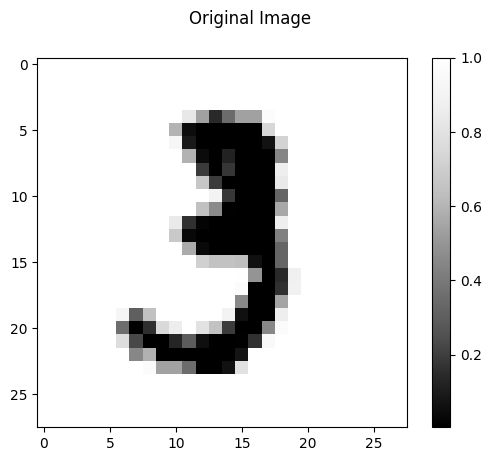

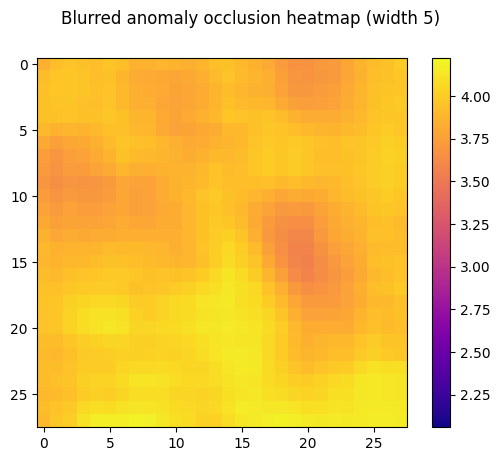

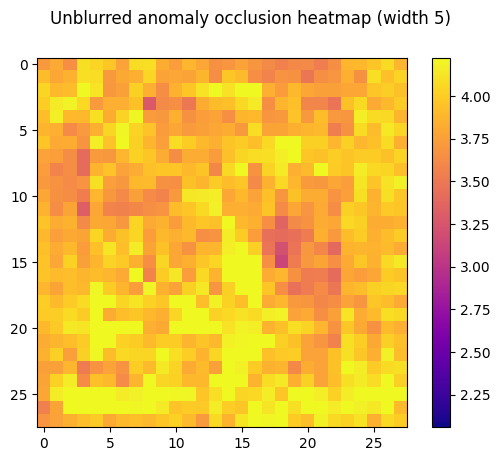

 11%|█         | 87/784 [00:00<00:01, 629.82it/s]

in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform


 19%|█▉        | 150/784 [00:02<00:10, 58.82it/s]

in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform


 23%|██▎       | 178/784 [00:03<00:12, 48.55it/s]

in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform


 25%|██▍       | 195/784 [00:03<00:12, 47.29it/s]

in transform
in transform
in transform
in transform
in transform


 27%|██▋       | 211/784 [00:03<00:10, 53.39it/s]

in transform
in transform
in transform
in transform
in transform


 28%|██▊       | 223/784 [00:03<00:10, 51.62it/s]

in transform
in transform
in transform
in transform
in transform


 30%|██▉       | 233/784 [00:04<00:12, 44.60it/s]

in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform


 31%|███       | 241/784 [00:04<00:14, 38.60it/s]

in transform
in transform
in transform
in transform
in transform


 33%|███▎      | 256/784 [00:04<00:12, 43.47it/s]

in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform


 33%|███▎      | 262/784 [00:05<00:14, 35.84it/s]

in transform
in transform
in transform
in transform
in transform


 35%|███▍      | 271/784 [00:05<00:17, 28.57it/s]

in transform
in transform
in transform
in transform
in transform


 36%|███▌      | 284/784 [00:05<00:13, 38.00it/s]

in transform
in transform
in transform
in transform
in transform


 37%|███▋      | 289/784 [00:06<00:15, 31.52it/s]

in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform


 38%|███▊      | 296/784 [00:06<00:23, 21.01it/s]

in transform
in transform
in transform
in transform


 38%|███▊      | 299/784 [00:06<00:24, 19.61it/s]

in transform
in transform
in transform
in transform


 41%|████      | 318/784 [00:07<00:09, 46.66it/s]

in transform
in transform
in transform
in transform
in transform
in transform


 41%|████▏     | 325/784 [00:07<00:16, 28.31it/s]

in transform
in transform
in transform
in transform
in transform


 42%|████▏     | 330/784 [00:07<00:17, 26.22it/s]

in transform
in transform
in transform
in transform
in transform


 44%|████▍     | 347/784 [00:07<00:09, 44.15it/s]

in transform
in transform
in transform
in transform
in transform


 45%|████▌     | 354/784 [00:08<00:12, 34.27it/s]

in transform
in transform
in transform
in transform


 46%|████▌     | 359/784 [00:08<00:14, 30.28it/s]

in transform
in transform
in transform
in transform
in transform


 48%|████▊     | 376/784 [00:08<00:08, 47.51it/s]

in transform
in transform
in transform
in transform
in transform


 49%|████▉     | 383/784 [00:08<00:10, 37.70it/s]

in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform


 52%|█████▏    | 404/784 [00:09<00:08, 46.29it/s]

in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform


 52%|█████▏    | 411/784 [00:09<00:10, 34.05it/s]

in transform
in transform
in transform
in transform


 53%|█████▎    | 416/784 [00:10<00:12, 30.41it/s]

in transform
in transform
in transform
in transform
in transform


 55%|█████▍    | 430/784 [00:10<00:08, 43.06it/s]

in transform
in transform
in transform
in transform
in transform


 56%|█████▌    | 436/784 [00:10<00:09, 35.57it/s]

in transform
in transform
in transform
in transform
in transform


 56%|█████▋    | 441/784 [00:10<00:10, 31.65it/s]

in transform
in transform
in transform
in transform
in transform


 58%|█████▊    | 458/784 [00:11<00:07, 42.58it/s]

in transform
in transform
in transform
in transform
in transform
in transform
in transform


 59%|█████▉    | 464/784 [00:11<00:11, 27.35it/s]

in transform
in transform
in transform
in transform


 60%|█████▉    | 469/784 [00:11<00:12, 25.31it/s]

in transform
in transform
in transform
in transform
in transform
in transform
in transform


 62%|██████▏   | 484/784 [00:12<00:09, 30.22it/s]

in transform
in transform
in transform
in transform


 62%|██████▏   | 489/784 [00:12<00:10, 29.32it/s]

in transform
in transform
in transform
in transform
in transform


 63%|██████▎   | 494/784 [00:12<00:10, 26.80it/s]

in transform
in transform
in transform
in transform
in transform


 64%|██████▍   | 502/784 [00:12<00:10, 25.90it/s]

in transform
in transform
in transform
in transform
in transform


 65%|██████▌   | 512/784 [00:13<00:07, 36.70it/s]

in transform
in transform
in transform
in transform
in transform


 66%|██████▋   | 521/784 [00:13<00:08, 32.50it/s]

in transform
in transform
in transform
in transform
in transform


 67%|██████▋   | 525/784 [00:13<00:08, 28.82it/s]

in transform
in transform
in transform
in transform
in transform


 67%|██████▋   | 529/784 [00:13<00:09, 26.56it/s]

in transform
in transform
in transform
in transform
in transform


 69%|██████▉   | 540/784 [00:13<00:06, 39.35it/s]

in transform
in transform
in transform
in transform
in transform


 70%|███████   | 549/784 [00:14<00:08, 28.73it/s]

in transform
in transform
in transform
in transform
in transform
in transform
in transform
in transform


 71%|███████   | 556/784 [00:14<00:09, 23.33it/s]

in transform
in transform
in transform
in transform
in transform


 72%|███████▏  | 567/784 [00:14<00:05, 36.49it/s]

in transform
in transform
in transform
in transform
in transform


 73%|███████▎  | 572/784 [00:15<00:06, 31.03it/s]

in transform
in transform
in transform
in transform
in transform


 74%|███████▍  | 580/784 [00:15<00:07, 26.08it/s]

in transform
in transform
in transform
in transform
in transform


 74%|███████▍  | 583/784 [00:15<00:08, 24.86it/s]

in transform
in transform
in transform
in transform
in transform


 76%|███████▌  | 594/784 [00:15<00:04, 38.50it/s]

in transform
in transform
in transform
in transform
in transform


 77%|███████▋  | 603/784 [00:16<00:06, 28.55it/s]

in transform
in transform
in transform
in transform
in transform


 77%|███████▋  | 607/784 [00:16<00:06, 26.58it/s]

in transform
in transform
in transform
in transform
in transform


 78%|███████▊  | 613/784 [00:16<00:07, 24.36it/s]

in transform
in transform
in transform
in transform
in transform


 80%|███████▉  | 625/784 [00:16<00:03, 40.43it/s]

in transform
in transform
in transform
in transform
in transform


 80%|████████  | 630/784 [00:17<00:04, 32.98it/s]

in transform
in transform
in transform
in transform
in transform


 81%|████████  | 634/784 [00:17<00:05, 29.17it/s]

in transform
in transform
in transform
in transform
in transform


 83%|████████▎ | 650/784 [00:17<00:03, 41.32it/s]

in transform
in transform
in transform
in transform
in transform


 84%|████████▎ | 655/784 [00:17<00:03, 34.23it/s]

in transform
in transform
in transform
in transform
in transform


 84%|████████▍ | 659/784 [00:18<00:03, 32.77it/s]

in transform
in transform
in transform
in transform
in transform


 85%|████████▌ | 667/784 [00:18<00:04, 26.77it/s]

in transform
in transform
in transform
in transform
in transform


 87%|████████▋ | 679/784 [00:18<00:02, 40.98it/s]

in transform
in transform
in transform
in transform
in transform


 87%|████████▋ | 684/784 [00:18<00:02, 33.84it/s]

in transform
in transform
in transform
in transform
in transform


 88%|████████▊ | 688/784 [00:18<00:03, 30.31it/s]

in transform
in transform
in transform
in transform


 89%|████████▊ | 695/784 [00:19<00:03, 25.40it/s]

in transform
in transform
in transform
in transform
in transform


 90%|█████████ | 708/784 [00:19<00:01, 42.01it/s]

in transform
in transform
in transform
in transform
in transform


 91%|█████████ | 713/784 [00:19<00:02, 33.79it/s]

in transform
in transform
in transform
in transform
in transform


 91%|█████████▏| 717/784 [00:19<00:02, 30.02it/s]

in transform
in transform
in transform
in transform
in transform


 94%|█████████▍| 736/784 [00:20<00:01, 46.99it/s]

in transform
in transform
in transform
in transform
in transform


 95%|█████████▍| 742/784 [00:20<00:01, 36.47it/s]

in transform
in transform
in transform
in transform
in transform


 95%|█████████▌| 747/784 [00:20<00:01, 31.59it/s]

in transform
in transform
in transform
in transform
in transform


100%|██████████| 784/784 [00:20<00:00, 37.78it/s]


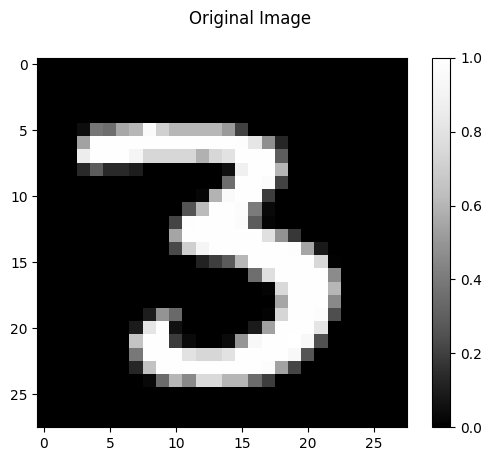

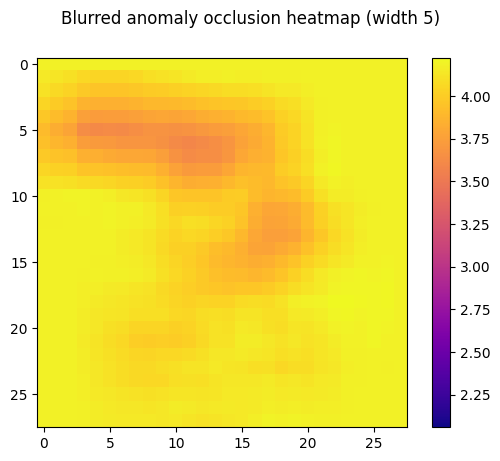

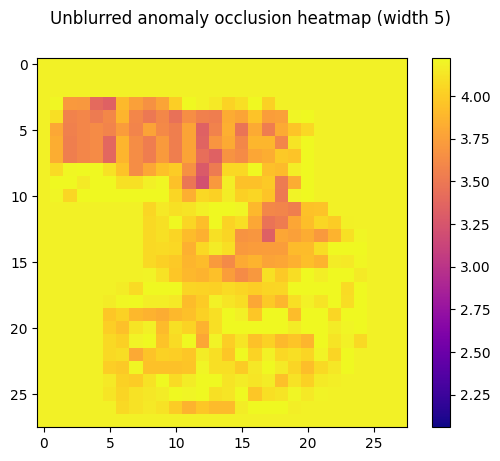

In [13]:
INDICES_TO_EXAMINE = [98, 10, 12]

from src.transforms.transform_library import TRANSFORM_LIBRARY
from src.utils import OcclusionTransform, occlusion_interpretability

METHOD = 'cblof_anomaly_validator_method'

resnet = TRANSFORM_LIBRARY['resnet50']()
resnet.initialize_transform(transform_kwargs={})
print(resnet)

for idx in INDICES_TO_EXAMINE:
    sample = dataset[idx]
    img = sample['mnist_image']
    img = img.reshape((1, 28, 28))
    occ = OcclusionTransform(width=5)
    occed = occ(img, (15, 15))

    model_results, model = results['unsupervised_anomaly_data_validator'][METHOD]['resnet50_backbone_mnist_image_results']
    res_min, res_max = min(model_results.values()), max(model_results.values())
    interp_results = occlusion_interpretability(img, model, occ, (res_min, res_max))